In [3]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
warnings.filterwarnings('ignore')

In [4]:
# Load the dataset
paths = []
labels = []

directory_path = 'C:\\Users\\91725\\Desktop\\SED\\TESS Toronto emotional speech set data'


In [5]:
for dirname, _, filenames in os.walk(directory_path):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())

    if len(paths) == 2800:
        break

print('Dataset is Loaded')

Dataset is Loaded


In [6]:
# Create a dataframe
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels

In [7]:
# Encode labels
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

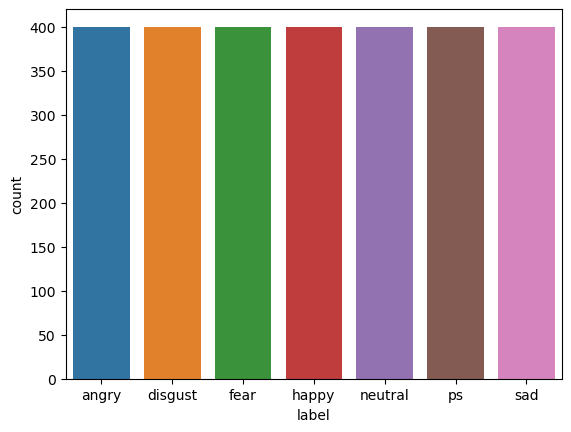

In [8]:
# Plot the count of each category
sns.countplot(data=df, x='label')
plt.show()

In [9]:
# Split the dataset
X = df['speech']
y = df['label_encoded']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
from joblib import Parallel, delayed

# Function to extract MFCC features
def extract_mfcc_parallel(file_path):
    if isinstance(file_path, np.ndarray):  
        y = file_path  
        sr = 22050  # Adjust the sample rate according to your data
    else:
        y, sr = librosa.load(file_path, duration=3, offset=0.5)
    
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfcc = librosa.util.fix_length(mfcc, size=40, axis=1)
    return mfcc

# Specify the number of parallel jobs
num_jobs = -1  # Use all available cores

# Extract MFCC features for training and validation sets in parallel
X_train_mfcc = np.array(Parallel(n_jobs=num_jobs)(delayed(extract_mfcc_parallel)(x) for x in X_train))
X_val_mfcc = np.array(Parallel(n_jobs=num_jobs)(delayed(extract_mfcc_parallel)(x) for x in X_val))



In [11]:
# Reshape to match the input shape of the model
X_train = X_train_mfcc.reshape(X_train_mfcc.shape[0], X_train_mfcc.shape[1], X_train_mfcc.shape[2])
X_val = X_val_mfcc.reshape(X_val_mfcc.shape[0], X_val_mfcc.shape[1], X_val_mfcc.shape[2])

# Print the shapes after reshaping
print("Shape of X_train after reshaping:", X_train.shape)
print("Shape of X_val after reshaping:", X_val.shape)

Shape of X_train after reshaping: (2240, 40, 40)
Shape of X_val after reshaping: (560, 40, 40)


In [12]:

# Convert labels to one-hot encoding
y_train_onehot = pd.get_dummies(y_train).values
y_val_onehot = pd.get_dummies(y_val).values

In [13]:
# Build the model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(128, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(7, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train_onehot, validation_data=(X_val, y_val_onehot), epochs=50, batch_size=64, callbacks=[early_stopping])


Epoch 1/50


35/35 [==============================] - 11s 180ms/step - loss: 1.3896 - accuracy: 0.5147 - val_loss: 1.2233 - val_accuracy: 0.7500
Epoch 2/50
35/35 [==============================] - 5s 154ms/step - loss: 0.5045 - accuracy: 0.8321 - val_loss: 0.7638 - val_accuracy: 0.8357
Epoch 3/50
35/35 [==============================] - 5s 152ms/step - loss: 0.2954 - accuracy: 0.9125 - val_loss: 0.4410 - val_accuracy: 0.9089
Epoch 4/50
35/35 [==============================] - 5s 151ms/step - loss: 0.1685 - accuracy: 0.9571 - val_loss: 0.2363 - val_accuracy: 0.9518
Epoch 5/50
35/35 [==============================] - 5s 153ms/step - loss: 0.1126 - accuracy: 0.9746 - val_loss: 0.1441 - val_accuracy: 0.9571
Epoch 6/50
35/35 [==============================] - 5s 152ms/step - loss: 0.0775 - accuracy: 0.9817 - val_loss: 0.1168 - val_accuracy: 0.9679
Epoch 7/50
35/35 [==============================] - 5s 151ms/step - loss: 0.0522 - accuracy: 0.9911 - val_loss: 0.0842 - val_accuracy: 0.9768
Ep

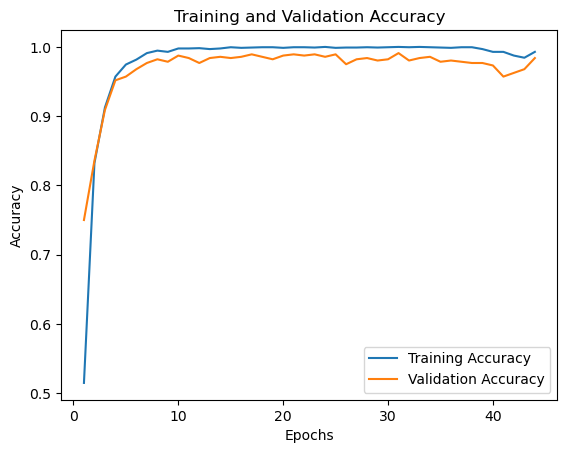

In [14]:
# Visualize training history
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

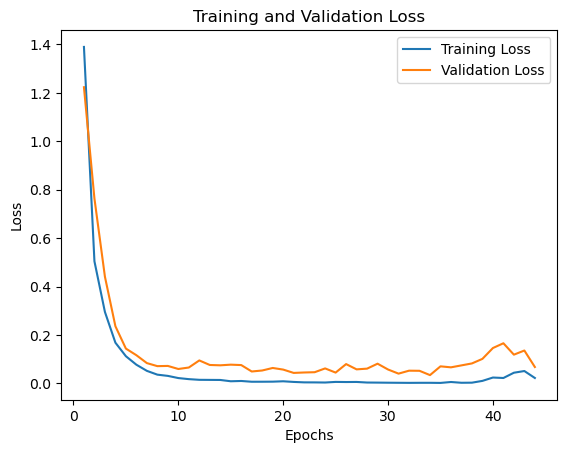

In [15]:
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

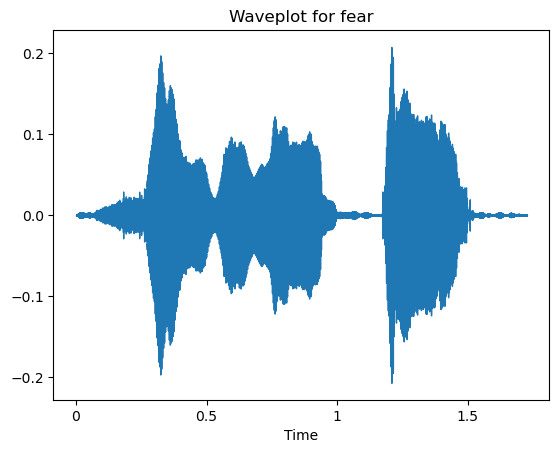

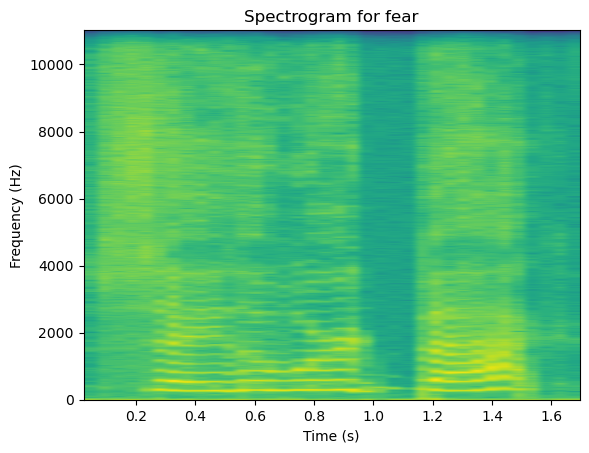

In [16]:
# Visualize waveplots and spectrograms for some examples
def visualize_audio_emotion(emotion):
    path = np.array(df['speech'][df['label']==emotion])[0]
    data, sampling_rate = librosa.load(path)
    
    # Waveplot
    librosa.display.waveshow(data, sr=sampling_rate)
    plt.title(f'Waveplot for {emotion}')
    plt.show()
    
    # Spectrogram
    Sxx, f, t, im = plt.specgram(data, NFFT=2048, Fs=sampling_rate, noverlap=1024)
    plt.title(f'Spectrogram for {emotion}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()
    
    # Audio Playback
    display(Audio(path))

# Visualize for a specific emotion (e.g., 'fear')
visualize_audio_emotion('fear')